# ODL and Tomography

This notebook demonstrates how to use ODL for tomographic problems.

## Contents

### Parametrization of Geometries

### Construction of Geometries

* Convenience functions for quick prototyping
* Class constructors for fine-grained control

### Creating and Using Ray Transforms

* Constructing `RayTransform` objects
* Interfacing with ASTRA

### Bonus: Using ASTRA Vec Geometries



---

## Parametrization of Geometries

A more detailed exposure of handling of geometries in ODL can be found in [the online documentation](https://odlgroup.github.io/odl/guide/geometry_guide.html).


ODL adopts a continuous view on acuisition geometries (this should not be too surprising anymore at this point). In principle, acquisition geometries define manifolds on which data is defined, but ODL makes no attempt at encoding those manifolds. Instead, **parameters** that would be mapped to the data manifold by a *parametrization* are used to represent a geometry.

---

**Example:**
The 2D Ray Transform can be defined as

$$
    \begin{align*}
        & R: L^2(\mathbb{R}^2) \to L^2(M),\quad Rf(\theta, v) = \int_{\mathbb{R}} f(t\theta + v)\, \mathrm{d}t, \\
        & |\theta| = 1,\ \langle \theta, v \rangle = 0.
    \end{align*}
$$

In this case, the data manifold would be the set

$$
    M = \{(\theta, v)\, |\, |\theta| = 1,\ \langle \theta, v \rangle = 0\}.
$$

However, it is much more intuitive and convenient (and allows a simpler implementation) to use *angles* and *shifts on detector* to encode the same information:

$$
    \begin{align*}
        & R: L^2(\mathbb{R}^2) \to L^2([0, \pi] \times \mathbb{R}),\quad Rf(\varphi, s) = \int_{\mathbb{R}} f\bigl( t\theta(\varphi) + s\theta^\perp(\varphi) \bigr)\, \mathrm{d}t, \\
        & \theta(\varphi) = (-\sin\varphi, \cos\varphi),\ \theta^\perp(\varphi) = (\cos\varphi, \sin\varphi).
    \end{align*}
$$

<img src="parallel2d_geom.png" alt="Parallel 2D Geometry" style="width: 600px;"/>

---

Some generic principles can be extracted from the example that allow to represent other, potentially more complex geometries:

* *A continuous function maps parameters to points on the data manifold.*

  In the example, this function is $(\varphi, s) \mapsto \bigl( \theta(\varphi), s \theta^\perp(\varphi) \bigr)$.

* *Parameters come from Cartesian products of intervals.*

  In the example, these intervals are $[0, \pi]$ and $\mathbb{R}$, although in practice, one would use a finite interval for the detector, of course.

* *Parameters can be separated into a "motion" part and a "detector" part.*

  This split is very natural for applications where the object is stationary and the detector moves (as in medical imaging). Other applications require a bit of phantasy to fit them to this acquisition model.

## Construction of Geometries

The `Geometry` classes in ODL give a lot of control over the definition of the vectors that determine their key properties. For cases when this flexibility is not needed, there exist convenience functions to quickly generate various common geometries.

### Convenience Factories for Geometries

The following functions exist for the creation of geometries (all in the `odl.tomo` subpackage):

* `parallel_beam_geometry`
* `cone_beam_geometry`
* `helical_geometry`

All helpers require as input a `space`, which should be a `DiscreteLp` instance. Its primary purpose is to determine the dimension of the geometry to create, but it is also used to find the required size of the detector to fully cover the reconstruction domain, and to find the minimum number of angles and detector pixels such that the Nyquist sampling condition is satisfied ([NW2001], pages 72--74).

Both the number of angles and the shape of the detector can be overridden via additional arguments.

Let's look at an example. We define the reconstruction domain as $[-1, 1] \times [-1, 1]$ and use a $200 \times 200$ grid for its discretization.

In [5]:
import odl

X = odl.uniform_discr([-1, -1], [1, 1], shape=(200, 200))

Next we create a parallel beam geometry suitable for this space. Here, the detector must be at least as large as the diameter of the reconstruction domain, to ensure that all rays intersecting the domain fall onto the detector. We can check that this is the case:

In [14]:
geom = odl.tomo.parallel_beam_geometry(X)
print('Geometry type:', type(geom))
print('Number of angles:', geom.motion_partition.size)
print('Number of detector elements:', geom.det_partition.size)
print('Detector extent:', float(geom.det_partition.extent))

Geometry type: <class 'odl.tomo.geometry.parallel.Parallel2dGeometry'>
Number of angles: 445
Number of detector elements: 285
Detector extent: 2.8284271247461903


Indeed, the length of the detector is $2\sqrt{2}$, enough to fully cover the given domain.

The conditions on the step sizes $\Delta\varphi$ and $\Delta s$ for angles and detector for full sampling are as follows [NW2001]:

$$
    \Delta\varphi \leq \frac{\pi}{\Omega}, \quad \Delta s \leq \frac{\pi}{\rho\Omega},
$$

where $\rho$ is the radius of the function support ($\sqrt{2}$ here), and $\Omega$ is the (essential) bandlimit of the discrete reconstruction space. We can choose $\Omega$ using the pixel size $\Delta x$ of the space:

$$
    \Omega = \frac{\pi}{\Delta x}.
$$

Thus, in our case, we expect that the generated geometry has an angle step of $\Delta\varphi \approx \Delta x / \sqrt{2}$ and a detector step size of $\Delta s \approx \Delta x$. Let's check this:

In [13]:
print('dx / dphi:', X.cell_sides[0] / geom.motion_partition.cell_sides[0])  # should be sqrt(2)
print('dx / ds:', X.cell_sides[0] / geom.det_partition.cell_sides[0])  # should be 1

dx / dphi: 1.41647899352
dx / ds: 1.00762716319


For small problems, these default choices are reasonable, but for larger problems, the number of angles can become unrealistically large, and it makes sense to manually set the number of angles.
Likewise, when the number of detector pixels is given by the application, one can set it manually. This will lead to larger pixels (full coverage is always guaranteed):

In [15]:
geom = odl.tomo.parallel_beam_geometry(X, num_angles=120)
print('Number of angles:', geom.motion_partition.size)
print('dx / dphi:', X.cell_sides[0] / geom.motion_partition.cell_sides[0])

Number of angles: 120
dx / dphi: 0.381971863421


In [16]:
geom = odl.tomo.parallel_beam_geometry(X, num_angles=120, det_shape=128)
print('Number of detector elements:', geom.det_partition.size)
print('Detector extent:', float(geom.det_partition.extent))  # should still be 2*sqrt(2)
print('dx / ds:', X.cell_sides[0] / geom.det_partition.cell_sides[0])

Number of detector elements: 128
Detector extent: 2.8284271247461903
dx / ds: 0.452548339959


#### `motion_partition`? `det_partition`?

In the examples above, discretization properties of the geometry were retrieved through the `motion_partition` and `det_partition` properties of the geometry. Those kinds of objects will be covered in the next section since the class constructors of geometries expect them as arguments.

### Geometry Class Constructors

The convenience factories for geometries are useful for creating quick "throw-away" geometry objects, but only cover a limited set of possibilities. For instance, it is not possible to create geometries with limited angle, data truncation or non-standard orientations. For such more advanced purposes, the class constructors should be used.

#### Partitions

The minimum information needed to construct a geometry is the set from which parameters can be taken, together with their discretizations (plus additional configuration depending on the type of geometry). In ODL, these "discretizations of intervals" or of Cartesian products of intervals are called **partitions**.

For a 1D interval, a partition is a division into small subintervals, together with a set of grid points. Most of the time, the grid points will be the midpoints of the subintervals, but not always.

---

**Example:**

The role of partitions is best explained with numerical integration. Suppose we have an interval $[c_0, c_n]$ subdivided into intervals $[c_i, c_{i+1}],\ i = 0, \dots, n-1$. For each subinterval, we can apply the [midpoint rule](https://en.wikipedia.org/wiki/Midpoint_rule) to integrate a function $f$:

$$
    \int_{c_i}^{c_{i+1}} f(t)\, \mathrm{d}t \approx (\underbrace{c_{i+1} - c_i}_{=:\Delta c_i})\, f\bigg( \underbrace{\frac{c_i + c_{i+1}}{2}}_{=:g_i} \bigg)
$$

We can sum up the values to get an approximation to the integral over the whole interval:

$$
    \int_{c_0}^{c_n} f(t)\, \mathrm{d}t \approx \sum_{i=0}^{n-1} \Delta c_i\, f(g_i).
$$

Thus the grid points $g_i$ play the role of the *sampling points* of the function $f$, whereas the lengths of the cells, $\Delta c_i$, act as *summation weights*.

---

In ODL, the combination of grid points and subintervals (or rather the multi-dimensional version of it) are called *partitions*. They are used extensively in `DiscreteLp` spaces and in `Geometry` objects.

Let's look at some examples of how to create and query properties of partitions. The single most used function to create them is `uniform_partition`:

In [22]:
part = odl.uniform_partition(0, 1, 10)
print('Partitioned interval:', part.set)
print('Subinterval boundaries:', part.cell_boundary_vecs[0])
print('Grid points:', part.grid.coord_vectors[0])

Partitioned interval: [0.0, 1.0]
Subinterval boundaries: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
Grid points: [ 0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95]


Clearly, the grid points do not coincide with the cell boundaries. This can sometimes lead to confusion, in particular when the grid points are already known and the cells are only a nuisance. For instance, in tomography, one typically has a list of angles and wants to create a geometry using them as-is (more on that case later).

For such cases, it is best to use the `nonuniform_partition` helper. It takes one or more *grid point vectors* and arranges the cells around those grid points in an adequate way:

In [24]:
points = [0, 0.4, 0.8, 1.0]
part = odl.nonuniform_partition(points)
print('Partitioned interval:', part.set)  # goes a bit beyond the grid points
print('Subinterval boundaries:', part.cell_boundary_vecs[0])
print('Grid points:', part.grid.coord_vectors[0])  # the exact same as `points`

print()

part = odl.nonuniform_partition(points, nodes_on_bdry=True)
print('Partitioned interval:', part.set)  # now the interval ends at the grid points
print('Subinterval boundaries:', part.cell_boundary_vecs[0])
print('Grid points:', part.grid.coord_vectors[0])  # the exact same as `points`

Partitioned interval: [-0.2, 1.1]
Subinterval boundaries: [-0.2  0.2  0.6  0.9  1.1]
Grid points: [ 0.   0.4  0.8  1. ]

Partitioned interval: [0.0, 1.0]
Subinterval boundaries: [ 0.   0.2  0.6  0.9  1. ]
Grid points: [ 0.   0.4  0.8  1. ]


#### Usage in Geometry Class Constructors

We are now ready to construct `Geometry` objects with the class constructor. The simplest one, `Parallel2dGeometry`, expects at least a partition for the angles and a partition for the detector:

In [25]:
import numpy as np

angles = np.linspace(0, np.pi, 180, endpoint=False)
angle_part = odl.nonuniform_partition(angles)
det_part = odl.uniform_partition(-1, 1, 100)

geom = odl.tomo.Parallel2dGeometry(angle_part, det_part)

print('Angle partition:', geom.motion_partition)
print('Detector partition:', geom.det_partition)

Angle partition: uniform_partition(-0.008727, 3.133, 180)
Detector partition: uniform_partition(-1.0, 1.0, 100)


The name `det_partition` is quite self-explanatory, but the name `motion_partition` does not match the above terminology of angle partition. That is because these notions are intended to be generic, and not all geometries are necessarily defined in terms of angles.

In the class constructor, there are defaults for many settings. For instance, in `Parallel2dGeometry`, the default `det_pos_init` is `(0, 1)`. We can override this to start at a different point, e.g., at `(1, 0)`. In this case, the other vectors, here only `det_axis_init`, rotates accordingly:

In [27]:
geom = odl.tomo.Parallel2dGeometry(angle_part, det_part, det_pos_init=(1, 0))

print('Initial detector reference point:', geom.det_pos_init)  # rotated by -90 degrees
print('The same:', geom.det_refpoint(0))
print('Initial detector axis:', geom.det_axis_init)  # also rotated by -90 degrees
print('The same:', geom.det_axis(0))

Initial detector reference point: [ 1.  0.]
The same: [ 1.  0.]
Initial detector axis: [  6.12323400e-17  -1.00000000e+00]
Initial detector axis: [  6.12323400e-17  -1.00000000e+00]


To find out more about all available options for a geometry, type `? <class>`:

In [29]:
? odl.tomo.Parallel2dGeometry

Init signature:  odl.tomo.Parallel2dGeometry(apart, dpart, det_pos_init=(0, 1), **kwargs)
Docstring:     
Parallel beam geometry in 2d.

The motion parameter is the counter-clockwise rotation angle around
the origin, and the detector is a line detector.

In the standard configuration, the detector is perpendicular to the
ray direction, its reference point is initially at ``(0, 1)``, and
the initial detector axis is ``(1, 0)``.

For details, check `the online docs
<https://odlgroup.github.io/odl/guide/geometry_guide.html>`_.
Init docstring:
Initialize a new instance.

Parameters
----------
apart : 1-dim. `RectPartition`
    Partition of the angle interval.
dpart : 1-dim. `RectPartition`
    Partition of the detector parameter interval.
det_pos_init : `array-like`, shape ``(2,)``, optional
    Initial position of the detector reference point.

Other Parameters
----------------
det_axis_init : `array-like` (shape ``(2,)``), optional
    Initial axis defining the detector orientation. The 

## Creating Ray Transform Operators (aka Using ASTRA from ODL)

To use a geometry for computation, one needs to create a `RayTransform` operator. It stands for the ray transform at the very top of this notebook.
The `RayTransform` class constructor requires a reconstruction space (the "domain", $X$ in the definition), and a `Geometry` object. The projection space ("range", $Y$ in the definition) is inferred from reconstruction space and geometry.

An optional `impl` argument allows to choose between different backends. By default, the fastest available is picked:

In [30]:
ray_trafo = odl.tomo.RayTransform(X, geom)
print('Ray transform domain:', ray_trafo.domain)
print('Ray transform range:', ray_trafo.range)
print('Ray transform backend:', ray_trafo.impl)

Ray transform domain: uniform_discr([-1., -1.], [ 1.,  1.], (200, 200))
Ray transform range: DiscreteLp(    FunctionSpace(IntervalProd([-0.0087, -1.    ], [ 3.1329,  1.    ])),
    uniform_partition([-0.0087, -1.    ], [ 3.1329,  1.    ], (180, 100)),
    rn((180, 100), weighting=0.0003491))
Ray transform backend: astra_cpu


This operator can now be used in any algorithm that expects an operator as input, e.g., the TV regularization code from an earlier notebook. To test whether it works, it can simply be called on a suitable input:

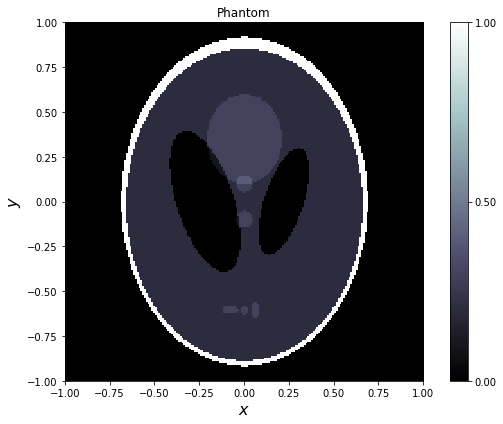

<Figure size 432x288 with 0 Axes>

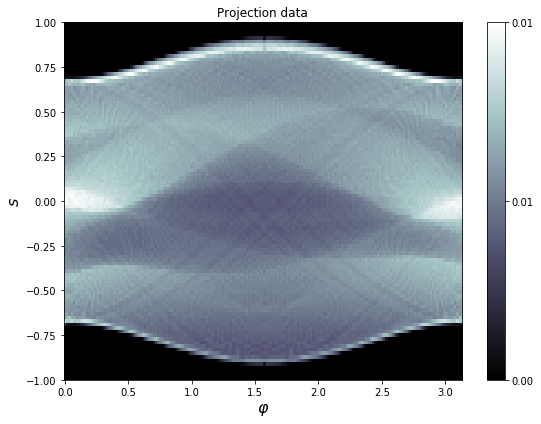

<Figure size 432x288 with 0 Axes>

In [32]:
x = odl.phantom.shepp_logan(X, modified=True)
data = ray_trafo(x)
x.show('Phantom', aspect=1, figsize=(8, 6))
data.show('Projection data', figsize=(8, 6))
pass

A nice thing about using `RayTransform` is that it takes care about all low-level details of interfacing with ASTRA, like generating the vector array, setting up the configuration dictionaries, creating and deleting IDs etc.
All this functionality is available in various modules in `odl.tomo.backends` for reference. The functions can be a good source  for education on low-level ASTRA features.

## Filtered Back-Projection

For most geometries, a quick reconstruction can be done using filtered back-projection. ODL has convenience functionality to create the reconstruction operators:

In [35]:
fbp_op = odl.tomo.fbp_op(ray_trafo, filter_type='Shepp-Logan', frequency_scaling=0.95)

The created operator can be customized with a selection of common filters, and the `frequency_scaling` argument that determines where the cutoff frequency (relative to Nyquist) should be placed.

Let's run it on our projection data:

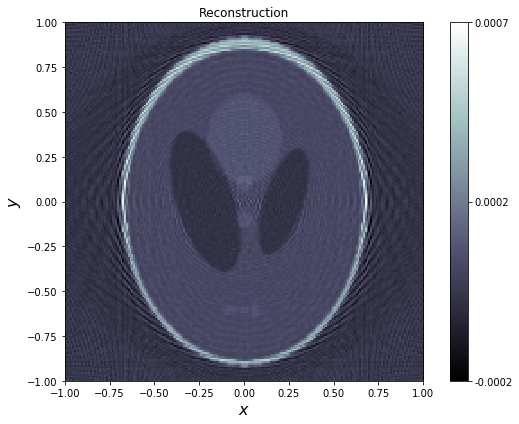

<Figure size 432x288 with 0 Axes>

In [37]:
recon = fbp_op(data)
recon.show('Reconstruction', aspect=1, figsize=(8, 6))
pass

## Bonus: Using ASTRA Vec Geometries Directly from ODL

Direct support for ASTRA vec geometries has not yet landed in the `master` branch. Using the feature reqires installation of a development version of ODL. Here's the command to do this (requires `git`):

In [ ]:
!pip install git+https://github.com/kohr-h/odl.git@issue-1023__vec_geometry

**Note:** To use this version likely requires a restart of the notebook kernel.

## Topics Not Covered Here

* Details on other geometries
* 

## References

[NW2001] Natterer, F and Wuebbeling, F. Mathematical Methods in Image Reconstruction. SIAM, 2001. https://dx.doi.org/10.1137/1.9780898718324